In [1]:
from functions import *
from import_data import *

from astropy.constants import R_sun, L_sun, sigma_sb
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

In [2]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()
df_stellar_params = stellar_params()
df_photometric_params = photometric_params()
df_BJ = BailerJones()

<font color='yellow' size=5> Calculate observed luminosity from photometric filters </font>


In [3]:
df_L = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_true": [None] * len(df_hmxb['id']),
                              "L_expected": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id']),
                              "logL_true/L_sun": [None] * len(df_hmxb['id']),
                              "Teff": [None] * len(df_hmxb['id']),
                              "logTeff": [None] * len(df_hmxb['id'])})

In [4]:
for i in range(df_hmxb.shape[0]):
    # Object id
    id = df_hmxb.loc[i, 'id']

    # Spectral type of object
    spectral_type = df_hmxb.loc[i, "ST"]

    # Effective temperature based on spectral type
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    if math.isnan(df_hmxb.loc[i, 'J']) == False and math.isnan(df_hmxb.loc[i, 'H']) == False and id in df_BJ['id'].tolist():
        # Expected (B-V)0 of object based on spectral type
        JH0 = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='(J-H)0')

        # Observed (B-V) of object based on simbad filters
        JHobs = df_hmxb.loc[i, 'J'] - df_hmxb.loc[i, 'H']

        # Bolometric correction (BC)
        BCh = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='BCh')

        # Distance
        distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

        # Calculate extinction
        Ah = 0.46 * (JHobs - JH0)

        # Calculate Absulute magnitude (visual)
        Mh = df_hmxb.loc[i, 'H'] - 5 * np.log10(distance) + 5 - Ah

        # Calculate bolomatric absolute magnitude
        Mbol = Mh + BCh

        # Calculate the luminosity in solar luminosities
        L = 10**((Mbol - 4.74) / (-2.5))

        # Put L in luminosity dataframe
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = Teff
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logTeff"] = np.log10(Teff)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "ST"] = spectral_type

    if id == 'Cen X-3':
        # Bolometric correction (BC)
        BCv = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='BCv')

        # Distance
        distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

        # Calculate extinction
        Av = 3.2 * 1.4

        # Calculate Absulute magnitude (visual)
        # V=12.27 From INTEGRAL V band
        Mv = 12.27 - 5 * np.log10(distance) + 5 - Av

        # Calculate bolomatric absolute magnitude
        Mbol = Mv + BCv

        # Calculate the luminosity in solar luminosities
        L = 10**((Mbol - 4.74) / (-2.5))

        # Put L in luminosity dataframe
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = Teff
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logTeff"] = np.log10(Teff)
        df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "ST"] = spectral_type

df_L = df_L.dropna(subset=['L_true']).reset_index(drop=True)

<font color='yellow' size=5>Calculate observed radius from observed luminosity and Teff from the models of Martins et al. (2005a) </font>

In [5]:
# Make radius dataframe
df_R = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "R_true": [None] * len(df_hmxb['id']),
                              "R_expected": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id'])})

In [6]:
for i in range(df_L.shape[0]):
    # id
    id = df_L.loc[i, 'id']

    # Spectral type
    spectral_type = df_L.loc[i, 'ST']

    # True luminosity
    L = df_L.loc[df_L["id"] == id, "L_true"].reset_index(drop=True).at[0]
    
    # Effective temperature from model
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Calculate the radius
    R = np.sqrt((L_sun.value / R_sun.value**2) * (L / (4 * np.pi * sigma_sb.value * Teff**4)))

    # Save luminosity in dataframe
    df_R.loc[df_R['id'] == id, "R_expected"] = R
    df_R.loc[df_R['id'] == id, "ST"] = spectral_type

<font color='yellow' size=5>Observed radius from Falenga et al. (2015) </font>

In [7]:
for i in range(df_falenga.shape[0]):
    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["ST"].reset_index(drop=True).at[0]

    # Put R in luminosity dataframe
    df_R.loc[df_R["id"] == id, "R_true"] = df_falenga['R_opt'][i]
    df_R.loc[df_R["id"] == id, "ST"] = spectral_type

In [8]:
# Calculate ratio
df_R["R_expected/R_true"] = df_R["R_expected"] / df_R["R_true"]

In [9]:
df_R = df_R.dropna(subset=['R_true', 'R_expected']).reset_index(drop=True)

<font color='yellow' size=5>Mass </font>
- M_HRD is determined from the position in the HRD as shown below in the code
- M_opt is the determined mass from Falenga et al. (2015) based on the orbital parameters

In [10]:
df_M = pd.read_excel("tables/M_expBONNSAI.xlsx")
df_M = pd.merge(df_M, df_falenga, on='id')[["id", "M_HRD", "M_opt"]]
df_M["M_opt/M_exp"] = df_M["M_opt"] / df_M["M_HRD"]

<font color='yellow' size=5>All parameters</font>

In [11]:
df_MRL = pd.merge(df_M, pd.merge(df_R, df_L, on='id'), on='id').drop(columns=['ST_y']).rename(columns={"ST_x": 'ST'})
df_MRL = df_MRL.drop(df_MRL.loc[df_MRL['id'] == 'OAO 1657-415'].index).drop(columns=['L_expected'])
df_MRL

,id,M_HRD,M_opt,M_opt/M_exp,R_true,R_expected,ST,R_expected/R_true,L_true,logL_true/L_sun,Teff,logTeff
0,SMC X-1,33,18.0,0.545455,15.0,21.416428,B0Ib,1.427762,315419.070772,5.498888,29558.0,4.470675
1,Vela X-1,36,26.0,0.722222,29.0,25.448836,B0.5Ib,0.877546,393287.31227,5.59471,28653.0,4.45717
2,LMC X-4,21,18.0,0.857143,7.4,8.514685,O8III,1.150633,79156.030773,4.898484,33179.0,4.520863
3,4U1700-37,45,46.0,1.022222,22.0,17.254783,O6Iaf+,0.784308,491984.222831,5.691951,36801.0,4.56586
4,4U1538-52,19,16.0,0.842105,13.0,11.013602,B0Ia,0.8472,83416.625613,4.921253,29558.0,4.470675
5,Cen X-3,48,24.0,0.500000,11.4,19.866079,O6.5III,1.742639,590274.227928,5.771054,35895.0,4.555034
6,XTE J1855-026,23,21.0,0.913043,22.0,14.048012,B0Iaep,0.638546,135713.664822,5.132624,29558.0,4.470675


<font color='yellow' size=5>Plots </font>

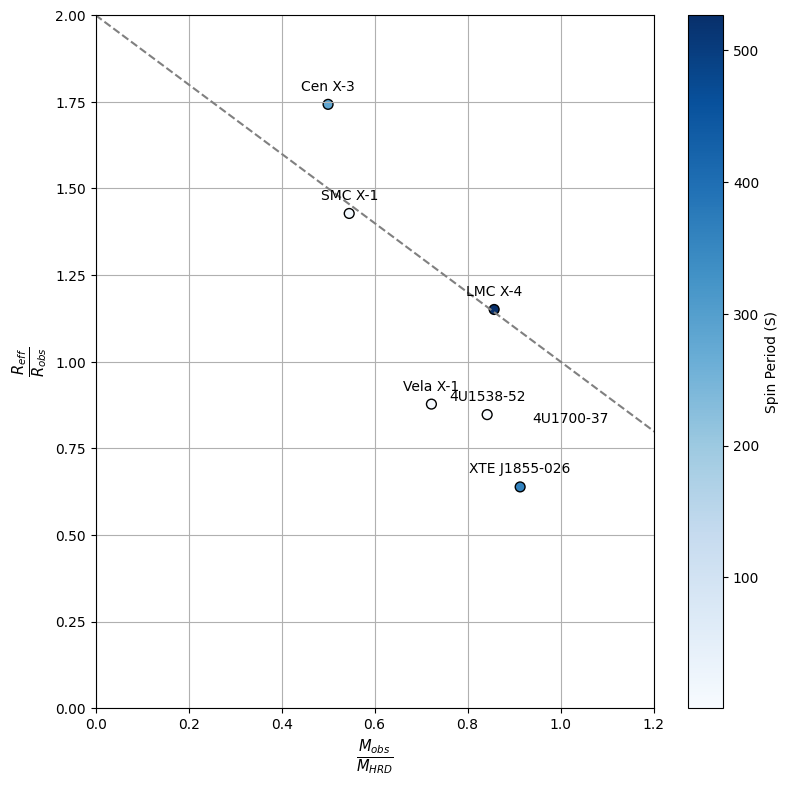

In [12]:
plt.figure(figsize=(9,9))
plt.scatter(df_MRL["M_opt/M_exp"], df_MRL["R_expected/R_true"], c=pd.merge(df_falenga, df_MRL, on='id')['P_spin'].tolist(), cmap='Blues', edgecolors='black', s=50)
plt.colorbar(label='Spin Period (S)')  # Add color bar with label
plt.plot([0, 2], [2, 0], linestyle='--', color='grey')
# Add labels to each point
for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["M_opt/M_exp"].tolist()[i], df_MRL["R_expected/R_true"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylim(0, 2)
plt.xlim(0, 1.2)
plt.grid(True)
plt.xlabel(r"$\frac{M_{obs}}{M_{HRD}}$", fontsize=15)
plt.ylabel(r"$\frac{R_{eff}}{R_{obs}}$", fontsize=15)
plt.show()

Objects in the Herzsprung Russel Diagram

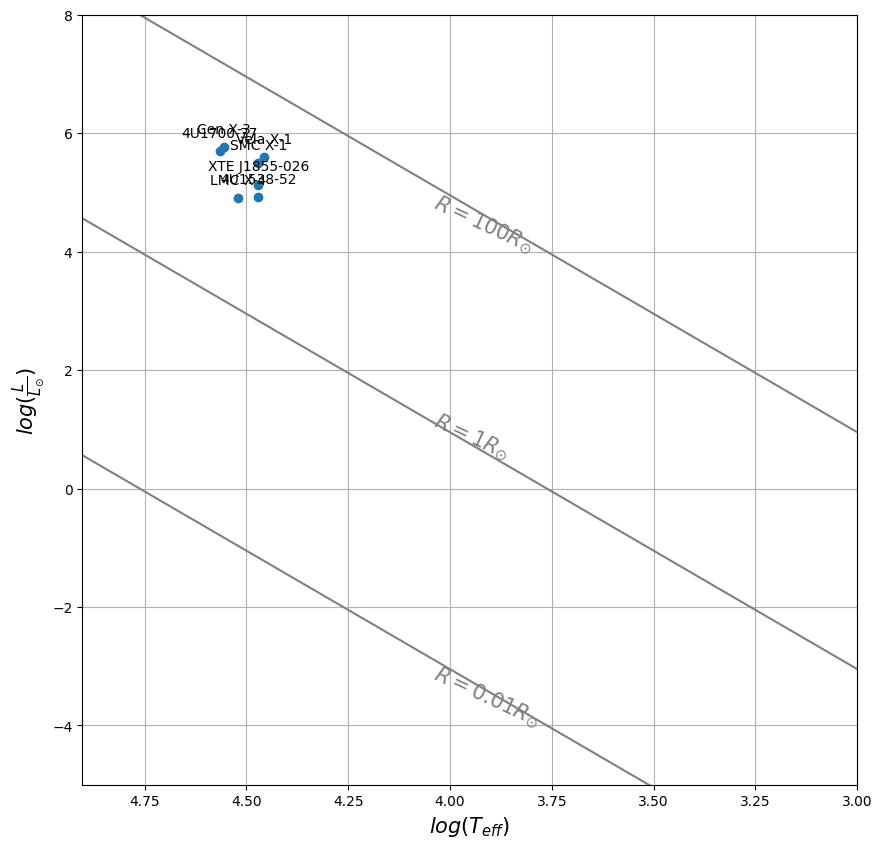

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(df_MRL["logTeff"], df_MRL["logL_true/L_sun"])
plt.ylim(-5, 8)
plt.xlim(np.log10(80000),np.log10(1000))
plt.xlabel(r"$log(T_{eff})$", fontsize=15)
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$", fontsize=15)

def L(Teff, R):
    # Some constants
    sigma = 5.67e-8 # W m-2 k-4
    Rsun = 696340000 # m
    Lsun = 3.86e26 # W

    return np.log10((4 * np.pi * sigma * Rsun**2) / Lsun) + 2 * np.log10(R) + 4 * np.log10(Teff)

radii = [0.01, 1, 100] # Solar radii
T_cR = [10**3, 10**5]
log_T_cR = [3, 5]
L_cR = []

for R in radii:
    save = []
    for T in T_cR:
        save.append(L(T, R))
    L_cR.append(save)

for L in L_cR:
    plt.plot(log_T_cR, L, color='grey')

for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["logTeff"].tolist()[i], df_MRL["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add text with radii to lines
plt.text(4.05, 4, s=r'$R = 100R_{\odot}$', rotation=-25, fontsize=15, color='grey')
plt.text(4.05, 0.5, s=r'$R = 1R_{\odot}$', rotation=-25, fontsize=15, color='grey')
plt.text(4.05, -4, s=r'$R = 0.01R_{\odot}$', rotation=-25, fontsize=15, color='grey')

plt.grid(True)
plt.show()

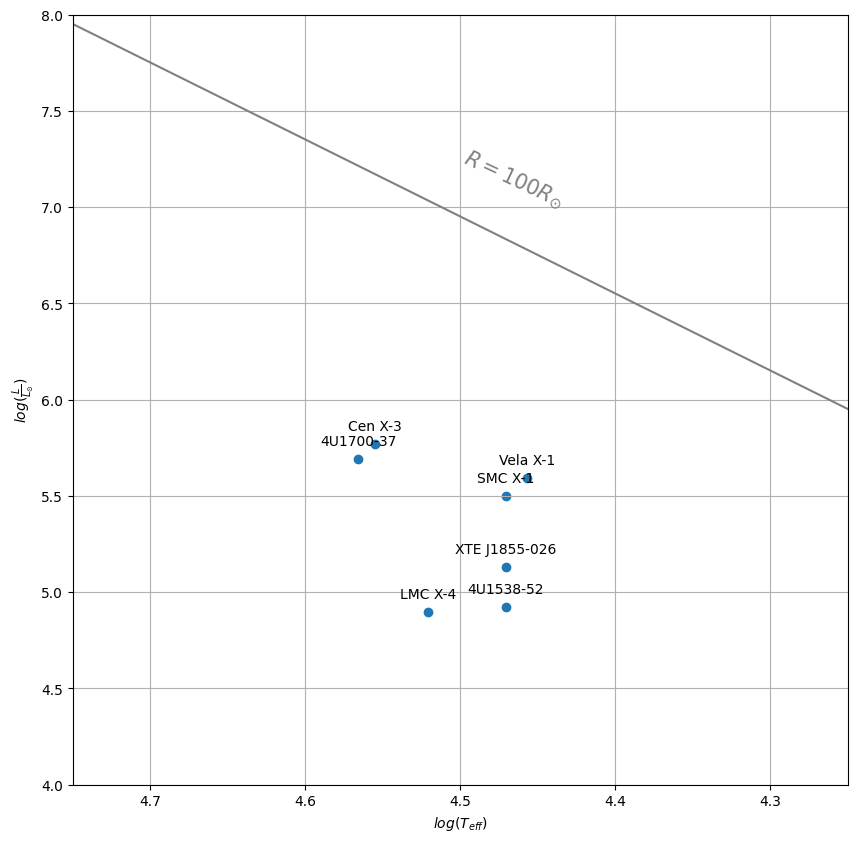

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(df_MRL["logTeff"], df_MRL["logL_true/L_sun"])
plt.ylim(4, 8)
plt.xlim(4.75,4.25)
plt.xlabel(r"$log(T_{eff})$")
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$")

def L(Teff, R):
    # Some constants
    sigma = 5.67e-8 # W m-2 k-4
    Rsun = 696340000 # m
    Lsun = 3.86e26 # W

    return np.log10((4 * np.pi * sigma * Rsun**2) / Lsun) + 2 * np.log10(R) + 4 * np.log10(Teff)

radii = [0.01, 1, 100] # Solar radii
T_cR = [10**3, 10**5]
log_T_cR = [3, 5]
L_cR = []

for R in radii:
    save = []
    for T in T_cR:
        save.append(L(T, R))
    L_cR.append(save)

for L in L_cR:
    plt.plot(log_T_cR, L, color='grey')

for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["logTeff"].tolist()[i], df_MRL["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add text with radii to lines
plt.text(4.5, 7, s=r'$R = 100R_{\odot}$', rotation=-25, fontsize=15, color='grey')
# plt.text(4.05, 0.5, s=r'$R = 1R_{\odot}$', rotation=-25, fontsize=15, color='grey')
# plt.text(4.05, -4, s=r'$R = 0.01R_{\odot}$', rotation=-25, fontsize=15, color='grey')

plt.grid(True)
plt.show()

<font color='yellow' size=5>Determine mass based on HRD evolutionary tracks</font>

In [15]:
# Set the metallicity value
ZY_values = [(0.02, 0.284), (0.03, 0.302), (0.04, 0.321)]
Z = ZY_values[0][0]
Y = ZY_values[0][1]

# Set the masses for which the evolutionary tracks will be drawn
M_values = [10, 11, 12, 14, 16, 18, 20, 24, 28, 30, 35, 40, 50]
M_values = [14, 20, 24, 40, 60, 80, 120]
M_values = ['{:07.3f}'.format(m) for m in M_values]

Determine the location of the ZAMS

In [16]:
L_ZAMS, T_ZAMS = ZAMS(Z=Z, Y=Y)

Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |ev

### Plot the evolutionary tracks

Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.


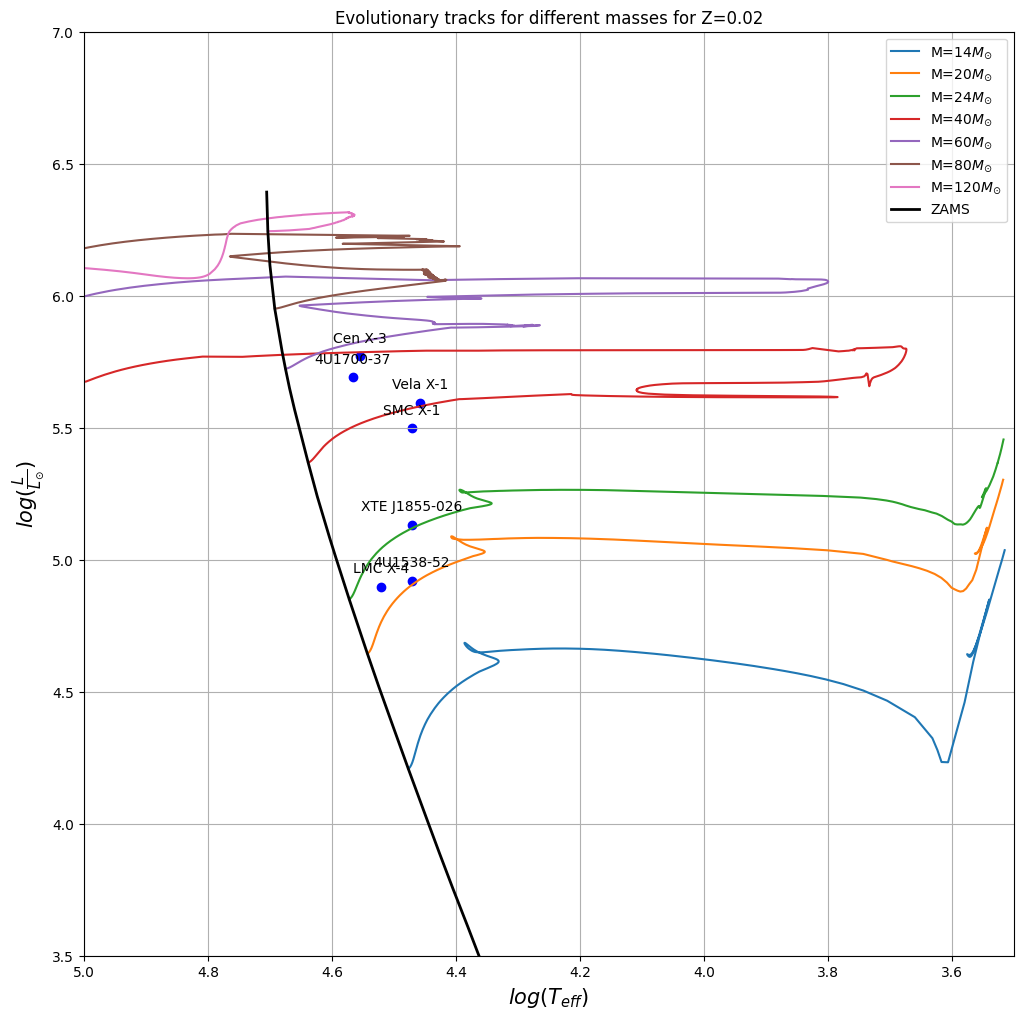

In [17]:
plt.figure(figsize=(12,12))
for M in M_values:
    df = evolutionary_track(Z=ZY_values[0][0], Y=ZY_values[0][1], M=M)

    ZAMS_index = find_ZAMS_index(df['H_CEN'].tolist())
    logL = df["LOG_L"].tolist()[ZAMS_index:]
    logT = df["LOG_TE"].tolist()[ZAMS_index:]

    logL = [float(x) for x in logL]
    logT = [float(x) for x in logT]

    plt.plot(logT, logL, label=(f'M={int(float(M))}'+r'$M_{\odot}$'))

for i, label in enumerate(df_MRL["id"].tolist()):
    plt.annotate(label, (df_MRL["logTeff"].tolist()[i], df_MRL["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.plot(T_ZAMS, L_ZAMS, label='ZAMS', color='black', linewidth=2)
plt.scatter(df_MRL['logTeff'], df_MRL['logL_true/L_sun'], color='blue')
plt.title(f'Evolutionary tracks for different masses for Z={ZY_values[0][0]}')
plt.xlabel(r"$log(T_{eff})$", fontsize=15)
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$", fontsize=15)
plt.ylim(3.5, 7)
plt.xlim(3.5, 5)
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

##### Determine the mass of Cen X-3 with the evolutionary tracks

Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.
Folder |evolutionary_tracks/extract/Z0.02Y0.284/| already exists.


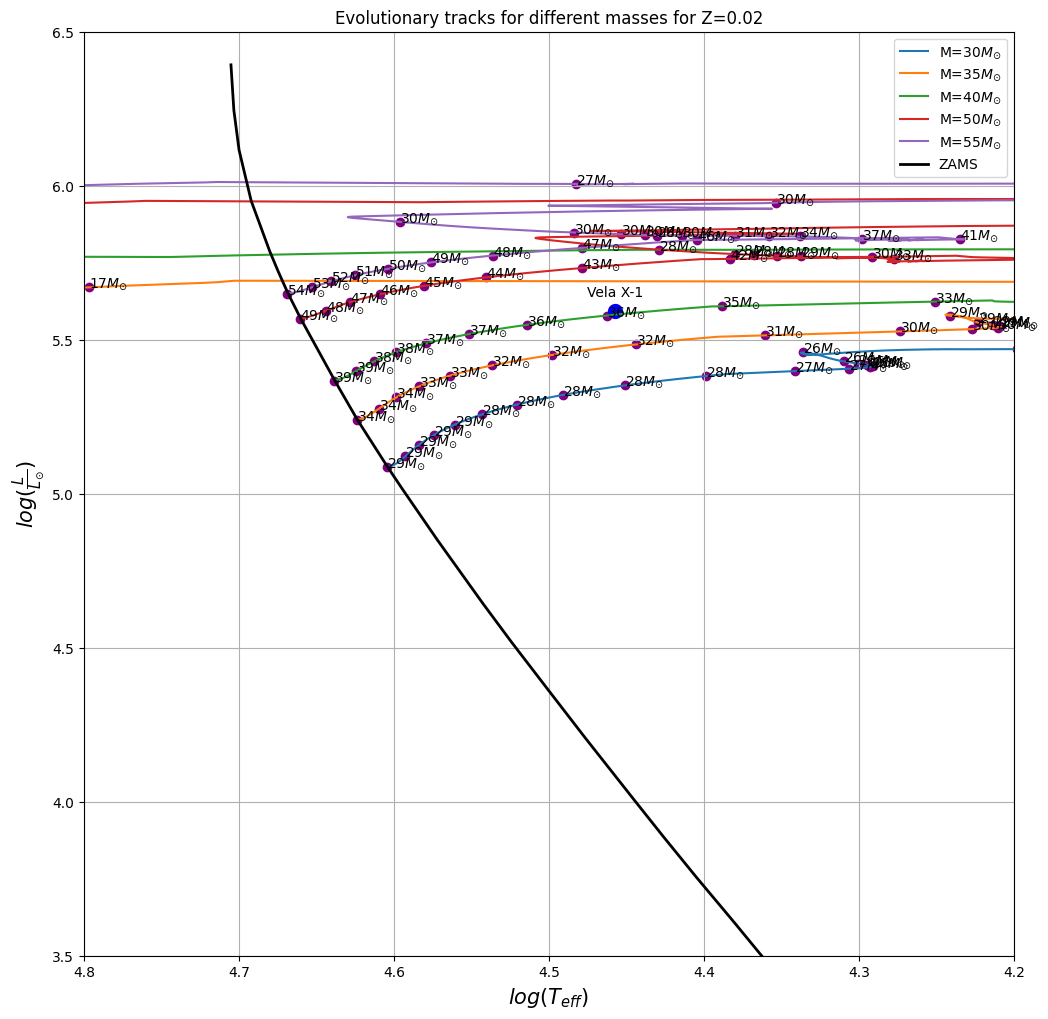

In [18]:
# Object
id = 'Vela X-1'
logTeff_obj = df_MRL.loc[df_MRL['id'] == id, 'logTeff'].reset_index(drop=True).at[0]
logL_obj = df_MRL.loc[df_MRL['id']== id, 'logL_true/L_sun'].reset_index(drop=True).at[0]

# Evolutionary tracks for the following masses
M_values_cen = [16, 18, 20, 24, 28, 30, 35, 40, 50, 55, 60, 65, 70, 80, 90, 95, 100]
M_values_cen = [30, 35, 40, 50, 55]
M_values_cen = ['{:07.3f}'.format(m) for m in M_values_cen]

# Plot evolutionary tracks
plt.figure(figsize=(12,12))
for M in M_values_cen:
    df = evolutionary_track(Z=ZY_values[0][0], Y=ZY_values[0][1], M=M)

    ZAMS_index = find_ZAMS_index(df['H_CEN'].tolist())
    logL = df["LOG_L"].tolist()[ZAMS_index:]
    logT = df["LOG_TE"].tolist()[ZAMS_index:]

    logL = [float(x) for x in logL]
    logT = [float(x) for x in logT]

    plt.plot(logT, logL, label=(f'M={int(float(M))}'+r'$M_{\odot}$'))

    for t in time_intervals(start_point= ZAMS_index, N_iterations=df.shape[0], N_intervals=30):
        M = df['MASS'][t]
        L = df['LOG_L'][t]
        T = df['LOG_TE'][t]
        plt.scatter([T], [L], color='purple')
        plt.annotate(f'{int(M)}' + r'$M_{\odot}$', (T, L))

# Label object
plt.annotate(id, (logTeff_obj, logL_obj), textcoords="offset points", xytext=(0,10), ha='center')

plt.plot(T_ZAMS, L_ZAMS, label='ZAMS', color='black', linewidth=2)
plt.scatter([logTeff_obj], [logL_obj], color='blue', linewidths=5)
plt.title(f'Evolutionary tracks for different masses for Z={ZY_values[0][0]}')
plt.xlabel(r"$log(T_{eff})$", fontsize=15)
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$", fontsize=15)
plt.ylim(3.5, 6.5)
plt.xlim(4.2, 4.8)
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.show()